# Example modeling process

### Imports

In [26]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from helpers import (get_training_observations, 
                     get_training_labels, 
                     get_protein_proportions)
from model_evaluation.model_comparison import eval_wrapper
import pandas as pd
import numpy as np
from joblib import dump
# Model specific imports
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt
import time
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

### Load training data and labels

In [22]:
x_train = get_training_observations()
y_train = get_training_labels()
le = load('../model_joblibs/xgb_labelEncoder.joblib')

Getting all training observations from 'metagenome_classification.db'...
Getting all training labels from 'metagenome_classification.db'...


In [52]:
x_train.head(10)

index,PF00001.19,PF00002.22,PF00003.20,PF00004.27,PF00005.25,PF00006.23,PF00007.20,PF00008.25,PF00009.25,PF00010.24,...,PF17216.1,PF17217.1,PF17218.1,PF17219.1,PF17220.1,PF17221.1,PF17222.1,PF17223.1,PF17224.1,PF17225.1
0,0.000000e+00,0.000000e+00,0.0,0.004020,0.006243,0.001039,0.0,0.000000,0.003265,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000e+00,0.000000e+00,0.0,0.003575,0.013739,0.001026,0.0,0.000000,0.002235,0.000007,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.376880e-07,2.188440e-07,0.0,0.001619,0.016218,0.000916,0.0,0.000002,0.001711,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000e+00,0.000000e+00,0.0,0.002737,0.019874,0.001785,0.0,0.000000,0.003570,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000e+00,0.000000e+00,0.0,0.001992,0.012389,0.001154,0.0,0.000013,0.002286,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000e+00,0.000000e+00,0.0,0.001684,0.016435,0.000931,0.0,0.000000,0.001806,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000e+00,0.000000e+00,0.0,0.001404,0.023274,0.000845,0.0,0.000000,0.001497,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000e+00,0.000000e+00,0.0,0.002301,0.015752,0.000925,0.0,0.000000,0.001843,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000000e+00,0.000000e+00,0.0,0.001885,0.014797,0.001012,0.0,0.000000,0.001689,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000000e+00,0.000000e+00,0.0,0.004574,0.013601,0.000995,0.0,0.000000,0.002402,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
y_train.head()

index,EMPO_1,EMPO_2,EMPO_3
0,Free-living,Saline,Hypersaline (saline)
1,Free-living,Saline,Water (saline)
2,Host-associated,Plant,Plant rhizosphere
3,Free-living,Non-saline,Soil (non-saline)
4,Free-living,Saline,Water (saline)


In [54]:
len(x_train.columns)

16306

### Data manipulation
Validation splits, dimensionality reduction, etc

In [23]:
# encode training label
y_train['EMPO_3'] = le.transform(y_train['EMPO_3'])
y_train['EMPO_3'].head()

0     5
1     9
2    14
3    13
4     9
Name: EMPO_3, dtype: int64

In [24]:
# Split into train/validation if not CV
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train['EMPO_3'], test_size=0.2, random_state=0)

In [ ]:
y_tr.nunique()

In [ ]:
y_val.nunique()

## Baseline

In [25]:
# function to plot the logloss
def eval_graphs(model):   
    results = model.evals_result()
    x_arr = np.arange(len(results['validation_0']['mlogloss']))+1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, results['validation_0']['mlogloss'], label='Train loss')
    if 'validation_1' in results:
        # plot validation set mlogloss
        ax.plot(x_arr, results['validation_1']['mlogloss'], label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    plt.title('Model LogLoss Curve')
    
    if 'merror' in results['validation_0']:
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.plot(x_arr, results['validation_0']['merror'], label='Train loss')
        if 'validation_1' in results:
            # plot validation set merror
              ax2.plot(x_arr, results['validation_1']['merror'], label='Validation loss')
        ax2.legend(fontsize=15)
        ax2.set_xlabel('Epoch', size=15)
        ax2.set_ylabel('MError', size=15)
        plt.title('Model MError Curve')
    plt.show()
    
    
def fit_model(model, x_tr=x_tr, y_tr=y_tr, eval_set=[(x_tr, y_tr), (x_val, y_val)], x_true=x_val, y_true=y_val):
    # fits and predict with model
    start = time.time()
    model.fit(x_tr,y_tr,
              eval_set=eval_set,
              early_stopping_rounds=10,
              verbose=0)
    stop = time.time()
    # predict validation data
    y_pred = model.predict(x_true)
    # print accuracy score 
    print("Training Set Accuracy Score on EMPO 3: ", accuracy_score(y_true, y_pred))
    # print model training time
    print(f"Model Training Time: {stop-start}s")
    return y_pred

def plt_eval_metrics(y_true, y_pred):
    # y_pred should be class labels when inputting into eval_wrapper
    y_pred_label = le.inverse_transform(y_pred.astype('int64'))
    y_true_label = le.inverse_transform(y_true.astype('int64'))
    eval_wrapper(y_true_label, y_pred_label)

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training Set Accuracy Score on EMPO 3:  0.924
Model Training Time: 1429.9537551403046s


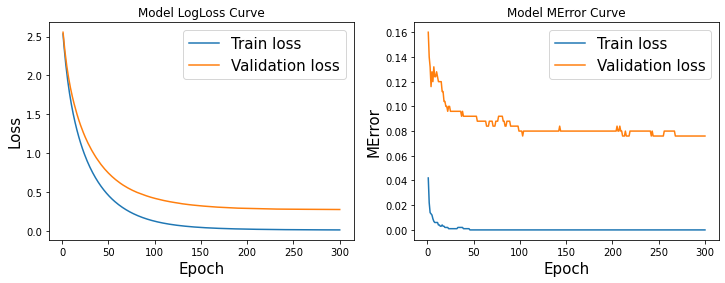

In [27]:
baseline_model = xgb.XGBClassifier(objective='multi:softmax',
                                eval_metric=['merror','mlogloss'],
                                n_estimators = 300,
                                eta=0.03,
                                use_label_encoder=False)
# fit model and get predictions on validation set
baseline_pred = fit_model(baseline_model)
# plot loss curve
eval_graphs(baseline_model)

In [28]:
baseline_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.03, eval_metric=['merror', 'mlogloss'], gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.0299999993, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False, ...)

Test Set Accuracy 0.924
Confusion Matrix


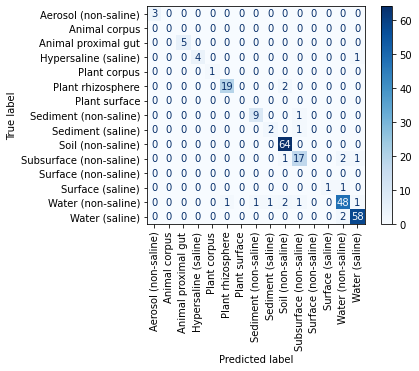

Classification Report


,precision,recall,f1-score,support
Aerosol (non-saline),1.000000,1.000000,1.000000,3
Animal proximal gut,1.000000,1.000000,1.000000,5
Hypersaline (saline),1.000000,0.800000,0.888889,5
Plant corpus,1.000000,1.000000,1.000000,1
Plant rhizosphere,0.950000,0.904762,0.926829,21
Sediment (non-saline),0.900000,0.900000,0.900000,10
Sediment (saline),0.666667,0.666667,0.666667,3
Soil (non-saline),0.927536,1.000000,0.962406,64
Subsurface (non-saline),0.850000,0.809524,0.829268,21
Surface (saline),1.000000,0.500000,0.666667,2


In [29]:
plt_eval_metrics(y_val, baseline_pred)

### Model Tuning

The baseline model has a training score that increases until 200 epochs. At later epochs, the log-loss and merror scores are fixed. From around 250 epochs, the variance is high but remains constant. The learning curve is ideal, with convergence and slight overfitting to demonstrate that the model is at optimal performance. However, we still still attempt fine-tuning hyperparameters to demonstrate that the baseline model is at optimal performance. Below are several key parameters that we can tune.

* increasing model complexity:
    * max_depth: integers from 8 to 20
    * min_child_weight: integers from 1 to 100
    * gamma: float between 0 and 4
* randomness:
    * lambda/reg_lambda: log scaling .001 to 1
    * alpha/reg_alpha: log scaling .001 to 10
    * learning_rate: log scaling .01 to 1
    * subsample: float between 0.2 and 1
    * colsample_bytree, colsample_bylevel, colsample_bynode: for each, floats between 0.3 and 1


In [ ]:
# initialize domain space for range of values
space={'max_depth': hp.quniform("max_depth", 15, 18, 1),
       'min_child_weight': hp.uniform('min_child_weight', 5, 7),
       'gamma': hp.uniform ('gamma', 0, 1),
        }
# define objective function
def objective(space):
    clf=xgb.XGBClassifier(objective='multi:softmax',
                          eta=0.03,
                          num_class=15,
                          eval_metric=['merror','mlogloss'],
                          n_estimators =300,
                          max_depth = int(space['max_depth']), 
                          min_child_weight=(space['min_child_weight']),
                          gamma = space['gamma'],
                          use_label_encoder=False)
    
    evaluation = [(x_tr, y_tr), (x_val, y_val)]
    # early stopping
    clf.fit(x_tr, y_tr,
            eval_set=evaluation,
            early_stopping_rounds=10,
            verbose=0)
    
    pred = clf.predict(x_val)
    accuracy = accuracy_score(y_val, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }
# optimization algorithm
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

# print results
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

  0%|                                   | 0/100 [00:00<?, ?trial/s, best loss=?]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.908                                                                           
  1%|▏               | 1/100 [19:17<31:50:38, 1157.97s/trial, best loss: -0.908]

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



In [1]:
# parameters that increase model complexity
# initialize domain space for range of values
space={'max_depth': hp.quniform("max_depth", 6, 20, 1),
       'min_child_weight': hp.uniform('min_child_weight', 1, 20),
       'gamma': hp.uniform ('gamma', 0, 1),
       'reg_lambda': hp.uniform('reg_lambda', 1, 50),
       'reg_alpha': hp.uniform('reg_alpha', 0, 50),
       'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1)
        }

# define objective function
def objective(space):
    clf=xgb.XGBClassifier(objective='multi:softmax',
                          eta=0.03,
                          num_class=15,
                          eval_metric=['merror','mlogloss'],
                          n_estimators =300,
                          max_depth = int(space['max_depth']), 
                          min_child_weight=(space['min_child_weight']),
                          gamma = space['gamma'],
                          reg_lambda = space['reg_lambda'],
                          reg_alpha = space['reg_alpha'],
                          colsample_bytree = space['colsample_bytree'],
                          use_label_encoder=False)
    
    evaluation = [(x_tr, y_tr), (x_val, y_val)]
    # early stopping
    clf.fit(x_tr, y_tr,
            eval_set=evaluation,
            early_stopping_rounds=10,
            verbose=0)
    
    pred = clf.predict(x_val)
    accuracy = accuracy_score(y_val, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

# optimization algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

# print results
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

  0%|                                   | 0/100 [00:00<?, ?trial/s, best loss=?]

job exception: name 'xgb' is not defined



  0%|                                   | 0/100 [00:00<?, ?trial/s, best loss=?]


NameError: name 'xgb' is not defined

With hyper parameter tuning did not produce a higher accuracy score.

Hyperparameter tuning did not produce a better accuracy score. 

The baseline model has an accuracy score of 0.924 and training time of 1079.

In [13]:
# Parameters for best and final model
best_model=xgb.XGBClassifier(objective='multi:softmax',
                             eta=0.03,
                             eval_metric=['merror','mlogloss'],
                             n_estimators =300,
                             max_depth=17, 
                             min_child_weight=6, 
                             )

Training Set Accuracy Score on EMPO 3:  0.876
Baseline Model Training Time: 716.4887356758118s


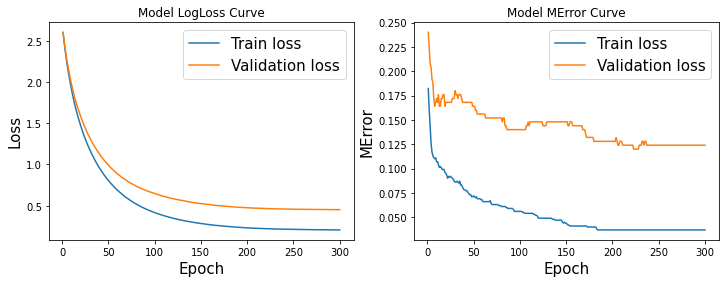

In [14]:
# fit model and get predictions on validation set
best_pred = fit_model(best_model)
# plot loss curve
eval_graphs(best_model)

### Retrain best model
After experimenting with models, retrain your favorite model using entire training set (including validation) before saving

In [14]:
start = time.time() 
# fit to entire training dataset
best_model.fit(x_train, y_train['EMPO_3'],
                eval_set=[(x_train, y_train['EMPO_3'])],
                verbose=0)
stop = time.time()
print(best_model)
print(f"Model Training Time: {stop-start}s" )

/Users/Sophie/opt/anaconda3/envs/xgb/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.03, eval_metric=['merror', 'mlogloss'], gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.0299999993, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, ...)
Model Training Time: 1716.4883699417114s


### Save fitted model

In [15]:
# Save best model as joblib or pkl file to 'model_joblibs' folder
dump(best_model, '../model_joblibs/xgb_model.joblib')

['../model_joblibs/xgb_model.joblib']